In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import warnings
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping
from typing import Dict, List, Tuple, Union
from optuna.samplers import TPESampler
import optuna

warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold


c:\Users\hugph\ML\s4e8\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv('train.csv', index_col = 'id')
test_df = pd.read_csv('test.csv', index_col = 'id')
secondary = pd.read_csv('secondary_data.csv', sep = ';')
tertiary = pd.read_csv('one_million_mushrooms.csv', sep = ';')
# tertiary_test = pd.read_csv('tertiary_data_2.csv', sep = ';') # ? Intended as test data but could be used for training?

In [3]:
train_df

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,e,9.29,f,NaN,n,t,NaN,NaN,w,12.14,...,b,NaN,w,u,w,t,g,NaN,d,u
3116941,e,10.88,s,NaN,w,t,d,c,p,6.65,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
3116942,p,7.82,x,e,e,f,a,NaN,w,9.51,...,NaN,NaN,y,NaN,w,t,z,NaN,d,a


In [4]:
train_df = pd.concat([train_df, secondary, tertiary], ignore_index=True)

In [5]:
train_df

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4216009,p,7.03,f,d,e,t,d,c,y,5.83,...,NaN,NaN,e,NaN,NaN,f,f,NaN,d,u
4216010,e,4.92,x,NaN,w,f,x,c,n,7.02,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
4216011,p,8.68,x,d,e,t,d,c,w,8.98,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
4216012,p,8.08,f,d,e,t,d,c,w,6.32,...,NaN,NaN,e,NaN,NaN,f,f,NaN,d,a


In [6]:
features = train_df.drop('class', axis = 1).columns.tolist()

In [7]:
features_with_high_null_values = [feature for feature in features if (train_df[feature].isna().sum()/len(train_df) * 100) > 20]
features_with_high_null_values

['cap-surface',
 'gill-spacing',
 'stem-root',
 'stem-surface',
 'veil-type',
 'veil-color',
 'spore-print-color']

In [8]:
categorical_features = train_df[features].select_dtypes(include = 'object').columns.tolist()
numerical_features = list(set(features) - set(categorical_features))

In [9]:
def cleaner(df, cols_to_filter):

    features_dict = {
        'cap_shape': ['x', 'f', 's', 'b', 'o', 'p', 'c'],
        'cap_surface': ['t', 's', 'y', 'h', 'g', 'd', 'k', 'e', 'i', 'w', 'l'],
        'cap_color': ['n', 'y', 'w', 'g', 'e', 'o', 'p', 'r', 'u', 'b', 'k', 'l'],
        'does_bruise_or_bleed': ['f', 't'],
        'gill_attachment': ['a', 'd', 'x', 'e', 's', 'p', 'f'],
        'gill_spacing': ['c', 'd', 'f'],
        'gill_color': ['w', 'n', 'y', 'p', 'g', 'o', 'k', 'f', 'r', 'e', 'b', 'u'],
        'stem_root': ['b', 's', 'r', 'c', 'f'],
        'stem_surface': ['s', 'y', 'i', 't', 'g', 'k', 'h', 'f'],
        'stem_color': ['w', 'n', 'y', 'g', 'o', 'e', 'u', 'p', 'k', 'r', 'l', 'b', 'f'],
        'veil_type': ['u'],
        'veil_color': ['w', 'y', 'n', 'u', 'k', 'e'],
        'has_ring': ['f', 't'],
        'ring_type': ['f', 'e', 'z', 'l', 'r', 'p', 'g', 'm'],
        'spore_print_color': ['k', 'p', 'w', 'n', 'r', 'u', 'g'],
        'habitat': ['d', 'g', 'l', 'm', 'h', 'w', 'p', 'u'],
        'season': ['a', 'u', 'w', 's']
    }
    
    for classes, cols  in zip(features_dict.keys(), cols_to_filter):
        df.loc[~df[cols].isin(features_dict[classes]), cols] = "missing"
        df[cols] = df[cols].astype('category')

    return df

In [10]:
def feature_engineering(df):
    df['stem-area'] = df['stem-height'] * df['stem-width']
    return df

In [11]:
train_df = cleaner(train_df, categorical_features)
test_df = cleaner(test_df, categorical_features)

In [12]:
# train_df = feature_engineering(train_df)
# test_df = feature_engineering(test_df)

In [13]:
knn_imputer = KNNImputer(n_neighbors = 3) # KNN imputer uses other numerical features to find values for the missing values

train_df['cap-diameter'] = knn_imputer.fit_transform(train_df[['cap-diameter']]) 
test_df['cap-diameter'] = knn_imputer.transform(test_df[['cap-diameter']])

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4216014 entries, 0 to 4216013
Data columns (total 21 columns):
 #   Column                Dtype   
---  ------                -----   
 0   class                 object  
 1   cap-diameter          float64 
 2   cap-shape             category
 3   cap-surface           category
 4   cap-color             category
 5   does-bruise-or-bleed  category
 6   gill-attachment       category
 7   gill-spacing          category
 8   gill-color            category
 9   stem-height           float64 
 10  stem-width            float64 
 11  stem-root             category
 12  stem-surface          category
 13  stem-color            category
 14  veil-type             category
 15  veil-color            category
 16  has-ring              category
 17  ring-type             category
 18  spore-print-color     category
 19  habitat               category
 20  season                category
dtypes: category(17), float64(3), object(1)
memory usage: 1

In [14]:
from sklearn.preprocessing import LabelEncoder

X = train_df.copy()
y = X.pop('class')

lab_enc = LabelEncoder().fit(y)
y = lab_enc.transform(y)

In [15]:
skfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)

In [16]:
for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
    print(f"train_index {len(train_idx)}")
    print(f"test_index {len(test_idx)}")


train_index 3372811
test_index 843203
train_index 3372811
test_index 843203
train_index 3372811
test_index 843203
train_index 3372811
test_index 843203
train_index 3372812
test_index 843202


In [17]:


def model_report(estimator, X, y, cv = 5):
    print('='*80)
    print(f"     Model: {estimator.__class__.__name__}")
    print('='*80)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 1/cv, shuffle = True, stratify = y, random_state = 42)

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score : {mcc.mean():.6f}")

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title('Confusion Matrix')
    plt.show()

    print()


In [18]:
def model_report_Kfold(estimator, X, y, n_splits = 5, random_state = 42):

    mccs = []

    skfold = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state=random_state)
    print('='*80)
    print(f"     Model: {estimator.__class__.__name__}")
    print('='*80)

    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]

        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        mcc = matthews_corrcoef(y_pred, y_test)
        mccs.append(mcc)
        print(f"Fold {fold} MCC Score : {mcc}")

    print(f"Overall MCC : {np.mean(mccs)}")



In [19]:
def model_trainer(model, X, y, n_splits = 5, random_state = 42):
    skfold = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = random_state)
    oof_probs, oof_mccs = [], []
    print('='*80)
    print(f"Training {model.__class__.__name__}")
    print('='*80, end = '\n')

    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mcc = matthews_corrcoef(y_pred, y_test)
        oof_mccs.append(mcc)
        oof_probs.append(model.predict_proba(test_df))

        print(f"--- Fold {fold + 1} MCC Score: {mcc:.6f}")
        print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
    return oof_probs, oof_mccs

In [20]:
def model_trainer_tts(model, X, y, random_state = 42):

    oof_probs, oof_mccs = [],[]

    print('='*80)
    print(f"Training {model.__class__.__name__}")
    print('='*80)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mcc = matthews_corrcoef(y_pred, y_test)
    oof_mccs.append(mcc)

    model.fit(X, y) # full dataset?

    oof_probs.append(model.predict_proba(test_df))

    print(f'MCC Score : {mcc}')
    
    return oof_probs, oof_mccs

     Model: LGBMClassifier
F1 Score : 0.993656
MCC Score : 0.985944


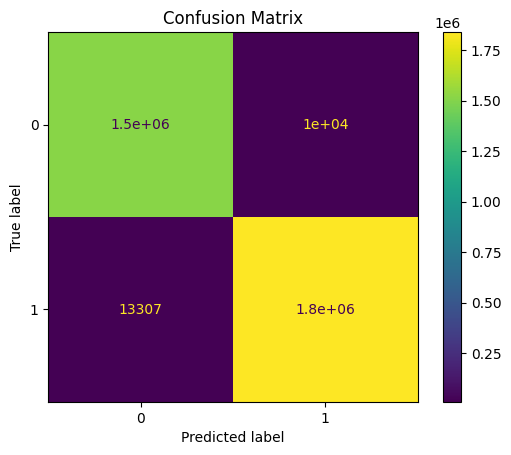

In [21]:
# lgbm_clf = LGBMClassifier(device = 'gpu', verbosity = -1)

# model_report(lgbm_clf, X, y)

Hyperparameter Tuning

In [ ]:
# class Model_gbdt:
#     def __init__(self, train: pd.DataFrame, test: pd.DataFrame, target: str, categorical_feats: List[str], base_params = None):

#         if base_params is None:
#             base_params = {}
#         self.train = train
#         self.test = test
#         self.model_dict: Dict[str, LGBMClassifier] = {}
#         self.test_predict_list: List[np.ndarray] = []
#         self.categorical_feats = categorical_feats
#         self.target = target
#         self.base_params = base_params
    
#     def objective(self, trial: optuna.Trial) -> float:
#          params = {
#             "max_depth": trial.suggest_int("max_depth", 2, 10),
#             "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#             "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
#             "n_estimators": trial.suggest_int("n_estimators", 50, 1500),
#             "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
#             "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
#             "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#             "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#             "lambda_l1": trial.suggest_float("lambda_l1", 0, 1),
#             "lambda_l2": trial.suggest_float("lambda_l2", 0, 1),
#             "min_split_gain": trial.suggest_float("min_split_gain", 0, 1),
#             "max_bin": trial.suggest_int("max_bin", 10, 1000),
#             "max_delta_step": trial.suggest_float("max_delta_step", 0, 1),
#             "path_smooth": trial.suggest_float("path_smooth", 0, 10),
#             "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
#             "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 1e-8, 1.0),
#             "max_cat_threshold": trial.suggest_int("max_cat_threshold", 2, 32),
#             "cat_l2": trial.suggest_float("cat_l2", 0, 100),
#             "cat_smooth": trial.suggest_float("cat_smooth", 0, 100),
#             "max_cat_to_onehot": trial.suggest_int("max_cat_to_onehot", 2, 32),
#             'cat_features': self.categorical_feats,
#             **self.base_params

#          }
#          scores, _, _ = self.fit(params)
#          return np.mean(scores)
    
#     def fit(self, params: Dict[str, Union[int, float, str, bool, List[str]]]) -> Tuple[List[float], List[np.ndarray], np.ndarray]:
            
#             label_columns = [self.target]
#             train_cols = [col for col in self.train.columns.to_list() if col not in label_columns]
#             scores = []
#             mskf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
#             oof_valid_preds = np.zeros((self.train[train_cols].shape[0], len(label_columns))) # np.zeros params is a tuple to set size
#             for fold, (train_idx, valid_idx) in enumerate(mskf.split(self.train[train_cols], self.train[label_columns])):

#                 X_train, y_train = self.train[train_cols].iloc[train_idx], self.train[label_columns].iloc[train_idx].values.ravel()

#                 X_valid, y_valid = self.train[train_cols].iloc[valid_idx], self.train[label_columns].iloc[valid_idx].values.ravel()

#                 model = LGBMClassifier(**params)
#                 model.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], callbacks=[early_stopping(250)]) # Early Stopping requires at least one validation data and one metric

#                 valid_preds = model.predict(X_valid)
#                 oof_valid_preds[valid_idx] = valid_preds.reshape(-1,1)

#                 mcc = matthews_corrcoef(y_valid, valid_preds)

#                 scores.append(mcc)
#                 self.model_dict[f'fold_{fold}'] = model

#             oof_score = matthews_corrcoef(self.train[label_columns], oof_valid_preds)
#             scores.append(oof_score)
#             print(f'The average Matthews Correlation Coefficient is {np.mean(scores)}')

#             return scores, self.test_predict_list, oof_valid_preds
    
#     def optimize(self, n_trials: int = 100) -> Dict[str, Union[int, float, str, bool]]:
#          study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed = 42))
#          study.optimize(self.objective, timeout = n_trials, show_progress_bar = True)
#          print("Best Trial:")
#          trial = study.best_trial

#          for key, value in trial.params.time():
#               print(f" {key}: {value}")
        
#          return study.best_params

In [ ]:
# model = Model_gbdt(train_df, test_df, 'class', categorical_features)
# best_params = model.optimize(n_trials = 100)
# scores, test_preds, oof_preds = model.fit(best_params)

In [22]:
# * LIGHTGBM GBDT

LGBM_params = {
    'max_depth': 13, 
     'num_leaves': 244, 
     'learning_rate': 0.06504856968981275, 
     'n_estimators': 1517, 
     'min_child_samples': 16, 
     'feature_fraction': 0.2403950683025824, 
     'subsample': 0.5290418060840998, 
     'colsample_bytree': 0.8795585311974417, 
     'lambda_l1': 0.6011150117432088, 
     'lambda_l2': 0.7080725777960455, 
     'min_split_gain': 0.020584494295802447, 
     'max_bin': 971, 
     'max_delta_step': 0.8324426408004217, 
     'path_smooth': 2.1233911067827616, 
     'min_data_in_leaf': 19, 
     'min_sum_hessian_in_leaf': 0.1834045180193887, 
     'max_cat_threshold': 11, 
     'cat_l2': 52.475643163223786, 
     'cat_smooth': 43.194501864211574, 
     'max_cat_to_onehot': 11,
     
     'categorical_feature': categorical_features,
     'boosting_type' : 'gbdt',
     }  


In [24]:
res, _ = model_trainer(LGBMClassifier(**LGBM_params, verbosity = -1, metric = 'binary_logloss'), X, y)

Training LGBMClassifier
--- Fold 1 MCC Score: 0.988610

---> Mean MCC Score: 0.988610 ± 0.000000




KeyboardInterrupt: 

In [ ]:
preds = lab_enc.inverse_transform(np.argmax(np.mean(res, axis = 0), axis = 1))
sub = pd.read_csv('sample_submission.csv')
sub['class'] = preds


In [ ]:
sub.to_csv('lightgbm_GBDT.csv', index = False)

In [23]:
# f, _ = model_trainer_tts(
# ), X, y)


In [24]:
# preds = lab_enc.inverse_transform(np.argmax(np.mean(f, axis = 0),axis = 1))
# sub = pd.read_csv('sample_submission.csv')
# sub['class'] = preds

In [25]:
# sub.to_csv('version_12_submission.csv', index = False)

Notes

In [26]:

# * MCC Score : 0.983147
# * MCC Score : 0.983182 ; noise is converted to missing
# * MCC Score : 0.983182 ; no difference in managing missing values
# * MCC Sore : 0.982143 ; leave np.nans and one hot encoding
# * MCC Score : 0.983161 ; leave np.nans
# * MCC Score : 0.983182 ; noise converted to missing ; KNN Imputer
# * MCC Score : 0.983123 ;  noise converted to missing ; KNN Imputer ; tree_method = 'approx'
# * MCC Score : 0.983062 ;  noise converted to missing ; feature engineering added stem-area
# * MCC Score : 0.983526 ; noise converted to missing ; added secondary data
# * MCC Score : 0.987624 ; noise converted to missing ; added secondary data ; added tertiary data
# * MCC Score : 0.988943 ; noise converted to missing ; added secondary data ; added tertiary data ; added tertiary2 data
# * MCC Score : 0.988451 ; noise converted to missing ; added secondary data ; added tertiary data ; best parameters after optuna hyperparameter tuning

Hyperparameter Tuning